In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [2]:
mi.set_variant('cuda_ad_rgb')

In [3]:
output_dir_base = 'inverse-rendering'
os.makedirs(output_dir_base, exist_ok=True)

% Load scene and parameters

In [4]:
scenes = [
    {
        'name': 'tire',
        'path': '../scenes/tire/scene.xml',
        'key': 'mat-tire.brdf_0.roughness.data',
        'restir_spp': 1,
        'mitsuba_spp': 1,
        'time': 90e3,
        'learning_rate': 0.005,
        'restir_mcap': 16,
        'integrator': 'restir_gi_dr',
        'max_depth': 2
    },
    {
        'name': 'ashtray',
        'path': '../scenes/ashtray/scene.xml',
        'key': 'mat-ashtray.brdf_0.anisotropic.data',
        'restir_spp': 1,
        'mitsuba_spp': 1,
        'time': 30e3,
        'learning_rate': 0.01,
        'restir_mcap': 16,
        'integrator': 'restir_gi_dr',
        'max_depth': 2
    },
    {
        'name': 'chalice',
        'path': '../scenes/chalice/scene.xml',
        'key': 'mat-chalice.brdf_0.roughness.data',
        'restir_spp': 1,
        'mitsuba_spp': 1,
        'time': 30e3,
        'learning_rate': 0.01,
        'restir_mcap': 16,
        'integrator': 'restir_gi_dr',
        'max_depth': 2
    },
    {
        'name': 'cbox',
        'path': '../scenes/cornell-box/scene.xml',
        'key': 'NewTallBoxBSDF.brdf_0.base_color.data',
        'restir_spp': 1,
        'mitsuba_spp': 1,
        'time': 30e3,
        'learning_rate': 0.1,
        'restir_mcap': 16,
        'integrator': 'restir_gi_dr',
        'max_depth': 3
    },
    {
        'name': 'staircase2',
        'path': '../scenes/staircase2/scene.xml',
        'key': 'FloorTilesBSDF.brdf_0.diffuse_reflectance.data',
        'restir_spp': 1,
        'mitsuba_spp': 1,
        'time': 30e3,
        'learning_rate': 0.1,
        'restir_mcap': 16,
        'integrator': 'restir_gi_dr',
        'max_depth': 2
    },
]
scene_info = scenes[0]

In [5]:
render_spp = 512
spp_forward = 32
equal_time_iterations = 20

In [6]:
scene_path, scene_name, key = scene_info['path'], scene_info['name'], scene_info['key']
output_dir = os.path.join(output_dir_base, scene_name)
os.makedirs(output_dir, exist_ok=True)

In [7]:
def convert_to_lum(grad_tensor, extend_dim=False):
    if len(grad_tensor.shape) != 3:
        return grad_tensor
    if grad_tensor.shape[2] == 1:
        if extend_dim:
            return grad_tensor
        return grad_tensor[:,:,0]
    grad_color = dr.unravel(mi.Color3f, dr.ravel(grad_tensor[...,:3]))
    grad_lum = mi.luminance(grad_color)
    shape = (grad_tensor.shape[0], grad_tensor.shape[1], 1) if extend_dim else \
        (grad_tensor.shape[0], grad_tensor.shape[1])
    return mi.TensorXf(grad_lum, shape=shape)

In [8]:
print(f'-------------------- Running {scene_name} -------------------------')

-------------------- Running tire -------------------------


In [9]:
scene = mi.load_file(scene_path, integrator=scene_info['integrator'], max_depth=scene_info['max_depth'])
is_base_color = 'base_color' in key
if 'learning_rate' in scene_info:
    learning_rate = scene_info['learning_rate']
elif is_base_color:
    learning_rate = 0.1
else:
    learning_rate = 0.01

In [10]:
image_gt = mi.render(scene, seed=0, spp=render_spp);
mi.util.write_bitmap(os.path.join(output_dir, 'render_gt.exr'), image_gt)

In [11]:
params = mi.traverse(scene)
param_ref = mi.TensorXf(params[key])
param_shape = np.array(params[key].shape)

In [12]:
param_initial = np.full(param_shape.tolist(), 0.5)
if param_shape[2] == 4:
    param_initial[:,:,3] = 1
    param_ref[:,:,3] = 1
params[key] = mi.TensorXf(param_initial)

In [13]:
params.update();

In [14]:
image_initial = mi.render(scene, seed=0, spp=render_spp)
mi.util.write_bitmap(os.path.join(output_dir, 'render_initial.exr'), image_initial)

In [15]:
opt = mi.ad.Adam(lr=learning_rate)
opt[key] = params[key]
params.update(opt);
scene.integrator().param_name = key

In [16]:
dr.set_flag(dr.JitFlag.KernelHistory, 1)

In [17]:
def get_elapsed_execution_time():
    hist = dr.kernel_history()
    elapsed_time = 0
    for entry in hist:
        elapsed_time += entry['execution_time']
    return elapsed_time

In [18]:
def relse(a, b):
    return dr.sqr(a - b) / (dr.sqr(b) + 1e-2)

In [19]:
def relmse(a, b):
    return dr.mean(relse(a, b))

In [20]:
def mae(a, b):
    return dr.mean(dr.abs(a - b))

In [21]:
def derivative_err(img, ref):
    return dr.sum(relse(img, ref)) / dr.count(dr.neq(ref.array, 0))

In [22]:
def loss_func(image):
    return relmse(image, image_gt)

In [23]:
params[key] = mi.TensorXf(param_initial)
params.update();

In [24]:
opt = mi.ad.Adam(lr=learning_rate)
opt[key] = params[key]
params.update(opt);

In [25]:
def get_equal_time_optimization(use_ref, n_time, spp_forward, spp_grad, M_cap=None):
    np.random.seed(0)

    # Reset initial params
    opt.reset(key)
    opt[key] = mi.TensorXf(param_initial)
    params.update(opt);
    scene.integrator().use_ref = use_ref
    scene.integrator().use_positivization = True
    scene.integrator().enable_temporal_reuse = True
    scene.integrator().M_cap = M_cap
    if scene_info['integrator'] != 'prb':
        scene.integrator().reset()
    it = 0
    total_time = 0
    times = []
    losses = []
    while True:
        # Perform a (noisy) differentiable rendering of the scene
        image = mi.render(scene, params, spp=spp_forward,
            spp_grad=spp_grad,
            seed=np.random.randint(2**31))

        # Evaluate the objective function from the current rendered image
        loss = loss_func(image)

        # Backpropagate through the rendering process
        dr.backward(loss)

        # Optimizer: take a gradient descent step
        opt.step()

        # Post-process the optimized parameters to ensure legal color values.
        opt[key] = dr.clamp(opt[key], 0.0, 1.0)

        # Update the scene state to the new optimized values
        params.update(opt)
        total_time += get_elapsed_execution_time()
        if total_time > n_time:
            break
        times.append(total_time / 1e3)
        losses.append(loss[0])
        print(f'-- Iteration {it} -- Loss {losses[-1]:.6f} --')
        it += 1
    return times, losses, mi.TensorXf(params[key])

% Run equal time optimization

In [26]:
restir_times, restir_losses, restir_param = \
    get_equal_time_optimization(False, scene_info['time'], spp_forward, scene_info['restir_spp'], M_cap=scene_info.get('restir_mcap', 16))

-- Iteration 0 -- Loss 0.483657 --
-- Iteration 1 -- Loss 0.499673 --
-- Iteration 2 -- Loss 0.490459 --
-- Iteration 3 -- Loss 0.486899 --
-- Iteration 4 -- Loss 0.502941 --
-- Iteration 5 -- Loss 0.499158 --
-- Iteration 6 -- Loss 0.506300 --
-- Iteration 7 -- Loss 0.514266 --
-- Iteration 8 -- Loss 0.519205 --
-- Iteration 9 -- Loss 0.517024 --
-- Iteration 10 -- Loss 0.511733 --
-- Iteration 11 -- Loss 0.535694 --
-- Iteration 12 -- Loss 0.536260 --
-- Iteration 13 -- Loss 0.528982 --
-- Iteration 14 -- Loss 0.546437 --
-- Iteration 15 -- Loss 0.542863 --
-- Iteration 16 -- Loss 0.552198 --
-- Iteration 17 -- Loss 0.543134 --
-- Iteration 18 -- Loss 0.557171 --
-- Iteration 19 -- Loss 0.550022 --
-- Iteration 20 -- Loss 0.554559 --
-- Iteration 21 -- Loss 0.562041 --
-- Iteration 22 -- Loss 0.554351 --
-- Iteration 23 -- Loss 0.574317 --
-- Iteration 24 -- Loss 0.561331 --
-- Iteration 25 -- Loss 0.568406 --
-- Iteration 26 -- Loss 0.590538 --
-- Iteration 27 -- Loss 0.567130 --
--

In [27]:
mitsuba_times, mitsuba_losses, mitsuba_param = \
    get_equal_time_optimization(True, scene_info['time'], spp_forward, scene_info['mitsuba_spp'])

-- Iteration 0 -- Loss 0.483657 --
-- Iteration 1 -- Loss 0.499670 --
-- Iteration 2 -- Loss 0.490397 --
-- Iteration 3 -- Loss 0.486341 --
-- Iteration 4 -- Loss 0.501011 --
-- Iteration 5 -- Loss 0.497250 --
-- Iteration 6 -- Loss 0.501355 --
-- Iteration 7 -- Loss 0.509231 --
-- Iteration 8 -- Loss 0.512031 --
-- Iteration 9 -- Loss 0.509266 --
-- Iteration 10 -- Loss 0.502940 --
-- Iteration 11 -- Loss 0.524225 --
-- Iteration 12 -- Loss 0.524351 --
-- Iteration 13 -- Loss 0.514397 --
-- Iteration 14 -- Loss 0.528359 --
-- Iteration 15 -- Loss 0.525666 --
-- Iteration 16 -- Loss 0.530219 --
-- Iteration 17 -- Loss 0.522631 --
-- Iteration 18 -- Loss 0.534031 --
-- Iteration 19 -- Loss 0.525928 --
-- Iteration 20 -- Loss 0.528167 --
-- Iteration 21 -- Loss 0.533880 --
-- Iteration 22 -- Loss 0.526870 --
-- Iteration 23 -- Loss 0.540372 --
-- Iteration 24 -- Loss 0.528997 --
-- Iteration 25 -- Loss 0.532396 --
-- Iteration 26 -- Loss 0.541805 --
-- Iteration 27 -- Loss 0.533364 --
--

% Output equal time optimization

<Figure size 640x480 with 0 Axes>

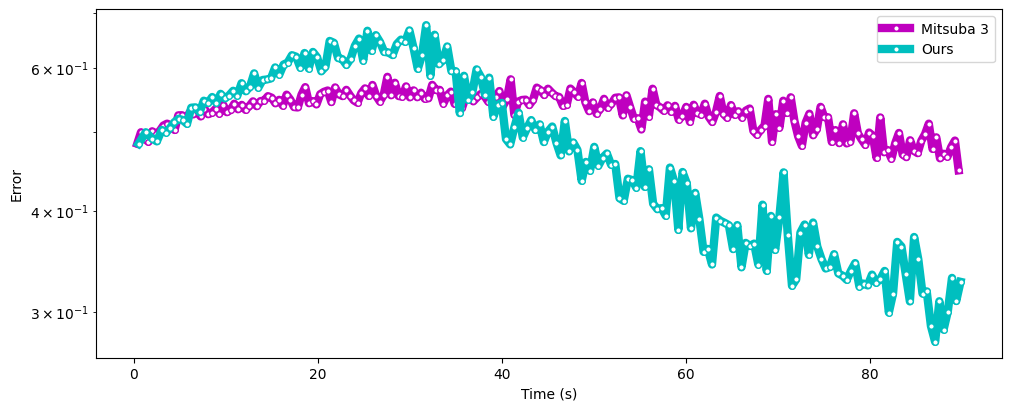

In [28]:
plt.clf()
plt.figure(figsize=(10, 4), dpi=100, constrained_layout=True);
plt.plot(mitsuba_times, mitsuba_losses, 'm-o', label='Mitsuba 3', linewidth=6.0, markersize=4.0, mfc='white')
plt.plot(restir_times, restir_losses, 'c-o', label='Ours', linewidth=6.0, markersize=4.0, mfc='white')
plt.xlabel('Time (s)');
plt.ylabel('Error');
plt.yscale('log')
plt.legend();
plt.savefig(os.path.join(output_dir, 'inv_convergence.pdf'), bbox_inches='tight', pad_inches=0.0)

% Output equal time final image

In [29]:
params[key] = mitsuba_param
params.update();
mitsuba_image = mi.render(scene, seed=0, spp=render_spp);
mi.util.write_bitmap(os.path.join(output_dir, 'render_final_mitsuba.exr'), mitsuba_image)

In [30]:
params[key] = restir_param
params.update();
restir_image = mi.render(scene, seed=0, spp=render_spp);
mi.util.write_bitmap(os.path.join(output_dir, 'render_final_restir.exr'), restir_image)

%

In [31]:
restir_img_err = loss_func(restir_image)[0]
mitsuba_img_err = loss_func(mitsuba_image)[0]

In [32]:
print(
    f'ReSTIR, error: {restir_img_err:.6e} ({restir_img_err/mitsuba_img_err:.5f}x)\n'
    f'Mitsuba, error: {mitsuba_img_err:.6e} (1.00x)\n'
)

ReSTIR, error: 6.732071e-02 (0.35640x)
Mitsuba, error: 1.888920e-01 (1.00x)



In [33]:
with open(os.path.join(output_dir, 'inv_convergence.json'), 'w') as f:
    json_str = json.dumps({
        'mitsuba_times': mitsuba_times,
        'mitsuba_losses': mitsuba_losses,
        'restir_times': restir_times,
        'restir_losses': restir_losses,
        'mitsuba_img_err': mitsuba_img_err,
        'restir_img_err': restir_img_err,
        'img_err_reduction': restir_img_err/mitsuba_img_err,
    }, indent=2)
    f.write(json_str)